# PyTorchで画像分類（補足済み）
## コピペするのではなく、このファイルを見ながら、元の「PyTorch_MLP_MNIST.ipynb」を仕上げていきましょう

- MLPによるMNIST（手書き文字）の分類
- ミニバッチ学習
- （ローカルPC上でCPU or GPU） or AWSクラウドGPU の利用

処理の流れ

1. デバイス設定
1. データセットの用意
1. 前処理
1. 入力データのチェック
1. ネットワークモデルの定義
1. 損失関数、最適化関数の定義
1. モデルの学習
1. 検証

補足：学習済みモデルの読書

1. 学習済みモデルを保存
1. 学習済みモデルを読込

In [1]:
import torch # Tensorを作成・操作するための機能、GPUの使用も設定
import torch.nn as nn # NNを構築する部品を提供
import torch.optim as optim # SGD, Adamなどの最適化関数や学習率を設定
from torchvision import datasets, transforms # 画像データの拡張やリサイズ、正規化などの前処理機能を提供
from torch.utils.data import DataLoader # ミニバッチ用、例えばDatasetから指定した数の画像と正解ラベルを取り出す

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns # matplotlibの機能補助

import time # 処理時間計測用

## 1. モデルの学習に用いるデバイスの設定

## 0.モデルの学習に用いるデバイスの設定

## 2＆3. データセットの用意しながら前処理も
### MNIST
- 60,000枚の訓練データ・・・モデルの学習に用いる
- 10,000枚のテストデータ（正確には検証データ）・・・学習済みモデルの評価に用いる（モデルの学習には用いない）

### それぞれのデータを格納する変数
- train_dataset：訓練データ
- test_dataset：テストデータ（正確には検証データ）

In [2]:
# 訓練データの用意
train_dataset = datasets.CIFAR10(
    root="./data", 
    train=True, download=True, # trainが Trueになっていること要チェック
    transform=transforms.ToTensor()
)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
# テストデータ（検証データ）の用意
test_dataset = datasets.CIFAR10(
    root='./data',
    train=False, download=True,# trainが Falseになっていること要チェック
    transform=transforms.ToTensor()
)

Files already downloaded and verified


In [4]:
# もしGPUが利用可能なら cuda が入る
device = "cuda" if torch.cuda.is_available() else "cpu"
# 上の1行（三項演算子）は下と同じ処理
# if torch.cuda.is_available():
#   device = 'cuda'
# else:
#   device = 'cpu'   

print('学習に使用するデバイス：',device)

学習に使用するデバイス： cuda


## 1. データセットの用意
### 変数名：train_dataset・・・訓練データ：モデルの学習に用いる
### 変数名：test_dataset・・・テストデータ（正確には検証データ）：モデルの学習に用いない、学習済みモデルの評価に用いる

In [5]:
# そもそも transform とはどのような処理が施された結果なのか、上の2つのセルを分解すると以下のとおり

# transform = transforms.Compose([
#     PyTorchのネットワークモデルに読み込ませるための変換処理
#     1. 画像をTensorに変換
#     2. 画像データ配列の軸を入れ替える　Channel Last → Channel First  つまり (H, W, C) → (C, H, W)  ※ Kerasは逆
#     3. 0-255の範囲 → 0.0-1.0 に変換
#     　　　　↓
#     transforms.ToTensor() 
# ])

# train_dataset = datasets.MNIST(
#     root="./data", 
#     train=True, download=True,
#     transform=transform　# 上で定義した transform　を代入
# )

# test_dataset = datasets.MNIST(
#     root="./data", 
#     train=False, download=True,
#     transform=transform　# 上で定義した transform　を代入
# )

## 前処理の続き：ミニバッチのサイズ(num_batches）を決める

### ミニバッチ学習：例えば 60,000 枚を 100 枚ずつに分けて学習する　※ちなみに60,000 枚を一度に学習することをバッチ学習という

### ミニバッチ学習用データを格納する変数
- train_dataloader：訓練データ（100枚 x 600セット）
- test_dataloader：テストデータ（100枚 x 100セット）

In [6]:
num_batches = 100

## 4. 入力データのチェック
### Tensorの形状を確認
### 画像の確認
### 画像データと正解ラベルの簡単な照合

In [7]:
# 100枚ごとに画像と教師データをセットにして train_dataloaderに入れる
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=num_batches, 
    shuffle=True
)
print('訓練データの概要：',train_dataloader.dataset)
print('ミニバッチサイズ：',train_dataloader.batch_size)

訓練データの概要： Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
ミニバッチサイズ： 100


In [8]:
# 100枚ごとに画像と教師データをセットにして test_dataloaderに入れる
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=num_batches, 
    shuffle=True
)
print('訓練データの概要：',test_dataloader.dataset)
print('ミニバッチサイズ：',test_dataloader.batch_size)

訓練データの概要： Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
ミニバッチサイズ： 100


In [9]:
# iter()はリストやタプルなど複数の要素を持つデータに対して、要素を最初から順番に取り出すことができる。
# 要素を取り出すときにはnext()を使う

train_iter = iter(train_dataloader)
imgs, labels = train_iter.next()
imgs.size() # サイズ・順番を確認　 # バッチサイズ、カラーチャンネル、高さ、幅　＝ 100、1、28、28　

torch.Size([100, 3, 32, 32])

In [10]:
labels # 正解ラベルの確認

tensor([7, 2, 9, 1, 4, 6, 4, 7, 0, 4, 6, 5, 6, 3, 6, 4, 9, 8, 2, 2, 9, 2, 3, 5,
        6, 8, 0, 0, 5, 8, 6, 7, 3, 3, 3, 4, 2, 1, 8, 6, 2, 8, 5, 7, 5, 1, 4, 8,
        0, 2, 2, 2, 7, 7, 6, 8, 3, 2, 8, 7, 3, 5, 3, 4, 1, 7, 3, 9, 7, 2, 1, 1,
        3, 1, 4, 1, 4, 5, 6, 0, 7, 6, 2, 2, 5, 4, 8, 1, 7, 2, 5, 7, 6, 7, 1, 1,
        5, 4, 7, 1])

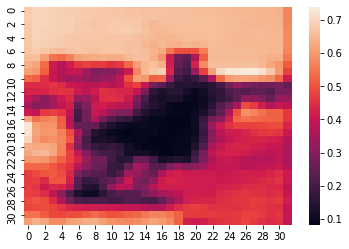

In [11]:
sns.heatmap(imgs[0].permute(1,2,0).numpy()[:,:,0]) # 画像確認
# permute 画像データ配列の軸の順番を入れ替える 0,1,2 → 1,2,0

In [12]:
labels[0] # 0番目のデータについて上の画像と下の数値が一致していることを確認

tensor(7)

## 5. ネットワークモデルの定義

In [13]:
class MLP(nn.Module):

    # モデルの初期化方法を定義
    def __init__(self):
        super().__init__() # 親クラスの初期化
        self.Peso_classifier = nn.Sequential( # 名付けは自由 Peso_claasifier # Sequentialで処理をまとめて記述
            # 中間層（隠れ層）
            # nn.Linerは全結合層
            # 第1層 入力数に注意（カラーチャンネル数 x 画像の高さ x 画像の幅）
#             nn.Linear(1 * 28 * 28, 400), # in_features= 1 * 28 * 28, out_features= 400
            nn.Linear(3 * 32 * 32, 400),
            nn.Dropout2d(0, 2),
            nn.ReLU(inplace=True), # ReLUの実行結果で元の値を置き換える　メモリ節約
            
            # 第2層
            nn.Linear(400, 200), # in_features= 400, out_features= 200
            nn.ReLU(inplace=True),

            # 第3層
            nn.Linear(200, 100),
            nn.ReLU(inplace=True),

            # 第4層
            nn.Linear(100, 10) # # in_features= 100, out_features= 10  ←　0 - 9 の10クラスで分類するため
        )

    # 順伝播の処理方法と定義
    def forward(self, x):
        output = self.Peso_classifier(x) # ←　上で付けた名前を間違えないように
        return output

In [14]:
model = MLP() # ネットワークモデルのインスタンス化（実際使えるようにする手続き）
model.to(device) # ネットワークモデルをデバイス CPU or GPU で使用するための設定

MLP(
  (Peso_classifier): Sequential(
    (0): Linear(in_features=3072, out_features=400, bias=True)
    (1): Dropout2d(p=0, inplace=2)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=400, out_features=200, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=200, out_features=100, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=100, out_features=10, bias=True)
  )
)

## 6. 損失関数、最適化関数の定義

In [15]:
criterion = nn.CrossEntropyLoss() # 損失関数の定義　多クラス分類なのでクロスエントロピー
# optimizer = optim.Adam(model.parameters(), lr=0.001) # 最適化関数を定義、lr = 学習率 詳しくは公式ドキュメント参照　https://pytorch.org/docs/stable/optim.html?highlight=adagrad#torch.optim.Adam
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


## 7. モデルの学習

In [16]:
%%time
num_epochs = 500 # 学習回数
losses = [] # 損失関数格納用

# 学習回数（num_epochs）分ループ
for epoch in range(num_epochs):
    running_loss = 0.0

    # ミニバッチ学習用のループ（100枚 x 600セットなので 600回ループ）
    for imgs, labels in train_dataloader:
        imgs = imgs.view(num_batches, -1) # Tensorの形状変換
        # 変換前：Tensor[(100, 1, 28, 28)]
        # 変更後：Tensor[(100, 784)]
        # (100,-1)と設定すると自動的に　1x28x28=784　の計算結果が自動的に挿入される
        imgs = imgs.to(device) # 画像データをデバイス(CPU or GPU）に送る
        labels = labels.to(device) # 正解ラベルのデータをデバイス(CPU or GPU）に送る

        optimizer.zero_grad() # 勾配を初期化（リセット）
        output = model(imgs) # 順伝播させて予測結果をoutputに代入

        loss = criterion(output, labels) # 予測結果と正解ラベルからLossを計算
        running_loss += loss.item() # Loss値を表示するために加算

        pred = torch.argmax(output, dim=1) #　0-9 のうち、最も確信度が高い「数字」をpredに代入

        loss.backward() # 逆伝播：勾配計算
        optimizer.step() # パラメータの更新

    running_loss /= len(train_dataloader) # ミニバッチのループ数で割合を算出
    losses.append(running_loss)

    print("epoch: {}, loss: {}".format(epoch, running_loss))

epoch: 0, loss: 2.3029121475219725
epoch: 1, loss: 2.2995783953666686
epoch: 2, loss: 2.2959736194610594
epoch: 3, loss: 2.292089169025421
epoch: 4, loss: 2.287793831348419
epoch: 5, loss: 2.2827953691482543
epoch: 6, loss: 2.276719856262207
epoch: 7, loss: 2.2690961985588074
epoch: 8, loss: 2.2594150438308716
epoch: 9, loss: 2.247084102630615
epoch: 10, loss: 2.2314562363624573
epoch: 11, loss: 2.2117703943252565
epoch: 12, loss: 2.1882536449432375
epoch: 13, loss: 2.1620075216293335
epoch: 14, loss: 2.1352027316093443
epoch: 15, loss: 2.1102829115390778
epoch: 16, loss: 2.088636036157608
epoch: 17, loss: 2.07003254199028
epoch: 18, loss: 2.053889605283737
epoch: 19, loss: 2.039501362800598
epoch: 20, loss: 2.0265723805427553
epoch: 21, loss: 2.014821240901947
epoch: 22, loss: 2.0038656408786775
epoch: 23, loss: 1.9936354410648347
epoch: 24, loss: 1.9841295523643494
epoch: 25, loss: 1.9748576035499572
epoch: 26, loss: 1.965978982925415
epoch: 27, loss: 1.9574732179641723
epoch: 28, lo

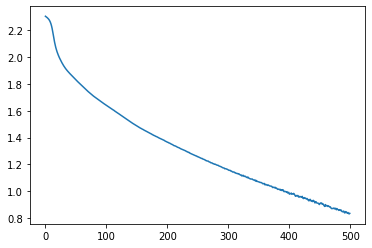

In [17]:
plt.plot(losses) # 誤差が減少していることを確認

## 8. 検証
## (1) 検証データから100枚ピックアップして検証

In [18]:
count = 0.0
for i in range(len(labels)): # 100枚で検証
    if labels[i] == pred[i]:
        count += 1

print('正解数: {} 個'.format(int(count)))
print('正解率: {} %' .format(count/len(labels) * 100))

正解数: 67 個
正解率: 67.0 %


## (2) 検証データ全体＝10,000枚　で検証

In [19]:
# テストデータが入ってる test_dataloaderで精度チェック
test_iter = iter(test_dataloader) # イテレータとは何者か　https://pouhon.net/python-iter/2067/
imgs, labels = test_iter.next() # 先頭から1バッチずつ取り出せる
labels

tensor([8, 1, 4, 6, 2, 1, 9, 5, 0, 6, 2, 7, 9, 1, 2, 8, 6, 9, 3, 8, 3, 3, 7, 0,
        0, 6, 8, 6, 7, 7, 0, 9, 1, 7, 0, 0, 8, 9, 3, 3, 6, 7, 9, 3, 2, 1, 1, 7,
        0, 9, 2, 1, 1, 6, 2, 0, 3, 7, 6, 3, 4, 3, 3, 1, 1, 2, 9, 7, 5, 3, 2, 2,
        6, 7, 5, 7, 7, 5, 2, 4, 4, 3, 4, 9, 2, 5, 5, 6, 3, 5, 6, 4, 8, 4, 2, 9,
        9, 7, 9, 4])

### 上記のとおり、(1)の100枚だけで検証した場合であっても、(2)の全体で検証した場合と結果とほぼ同じになる

### モデルの検証方法については次回以降で学習

# 学習済みモデルを保存する

In [20]:
params = model.state_dict()
torch.save(params, 'Peso_model.prm')

# 学習済みモデルを読み込む

In [21]:
param_load = torch.load('Peso_model.prm')
model.load_state_dict(param_load)

<All keys matched successfully>

In [22]:
imgs_tensor = imgs.view(100,-1).to(device)
output = model(imgs_tensor)
pred = torch.argmax(output, dim=1)
pred

tensor([8, 1, 2, 6, 4, 9, 1, 5, 0, 6, 4, 7, 8, 8, 6, 8, 6, 9, 3, 8, 6, 7, 8, 9,
        9, 6, 8, 6, 4, 7, 1, 0, 9, 2, 9, 0, 8, 9, 0, 5, 6, 4, 9, 5, 6, 1, 3, 7,
        4, 1, 9, 0, 1, 6, 6, 0, 3, 7, 2, 7, 2, 6, 7, 9, 1, 2, 1, 7, 5, 3, 0, 3,
        6, 4, 6, 7, 2, 1, 2, 2, 1, 3, 4, 9, 2, 5, 5, 6, 9, 5, 3, 2, 8, 2, 5, 9,
        9, 7, 6, 3], device='cuda:0')

In [23]:
test_acc = 0
total = 0
for images, labels in test_dataloader: # 10,000枚で検証
    images, labels = images.view(num_batches, -1).to(device), labels.to(device)
    outputs = model(images)
    pred = torch.argmax(outputs, dim=1) 
    test_acc += (pred == labels).sum().item()
    # 上2行と同じ処理　test_acc += (outputs.max(1)[1] == labels).sum().item()
    total += labels.size(0)

print('正解数： {} 個'.format(int(test_acc)))    
print('正解率： {} %'.format(100 * test_acc / total))

正解数： 5324 個
正解率： 53.24 %


In [25]:
s = 0

for imgs, labels in test_dataloader:
    labels = labels.to(device)
    imgs_gpu = imgs.view(num_batches, -1).to(device)
    output = model(imgs_gpu)
    pred = torch.argmax(output, dim=1)
    s += sum(labels==pred)
    
int(s)/100

53.24